In [5]:
%matplotlib notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time
from scipy.optimize import minimize
from climin.util import optimizer
import theano
import theano.tensor as T
from itertools import izip, cycle, imap, repeat, islice
from pprint import pprint
from functools import partial

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from schlichtanders.myfunctools import compose, summap, meanmap, Average, compose_fmap, as_wrapper
from schlichtanders.mygenerators import chunk, every
from schlichtanders.mycontextmanagers import ignored

In [3]:
from theano_models.visualization import d3viz
from IPython.display import IFrame

In [4]:
from theano_models import (Merge, fix_params, normalizing_flow, variational_bayes,
                           Reparameterize, Flatten, Center, check_all_identities)
from theano_models.tools import as_tensor_variable, softplus, softplus_inv, squareplus, squareplus_inv, L1
                           
import theano_models.postmaps as post
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Deterministic Model - one dimensional

## target

In [ ]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [ ]:
f_target = target.function()
example_target = [7]
f_target(example_target)  # caution, needs vector not scalar input

In [ ]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

In [ ]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

## model

In [ ]:
model_ = dm.RadialTransform(input=xs[0])
model_

TODO softplus gives immediate precision loss, while e.g. squarepos works like a charm

    # model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), 'parameters')

In [ ]:
model = Merge(model_, Reparameterize(model_['parameters_positive'], squareplus, squareplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

## visualization

In [ ]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    
    # model:
    f_model = model.function(givens=givens)
    model_ys = np.array([f_model(x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(post.scipy_postmap, post.flat_numericalize_postmap, post.deterministic_optimizer_postmap)
scipy_kwargs = postmap(model, mapreduce=summap)
scipy_kwargs

In [ ]:
fit = minimize(
    args=(ys,xs),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}),
    **scipy_kwargs
); fit

Fix fitted parameters into model.

We need to further build a givens dictionary supply the input-info which usually is given when used as theano.function(model['inputs'], model['outputs']).

In [ ]:
fit.x

In [ ]:
model['flat'] = fit.x

In [ ]:
[(p.name, p.eval()) for p in model_['parameters_positive']]

In [ ]:
[(p.name, p.eval()) for p in model_['parameters']]

# two dimensions

## target

In [ ]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [ ]:
f_target2d = target2d.function()
example_target2d = [7, 4]
f_target2d(example_target2d)  # caution, needs vector not scalar input

In [ ]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

In [ ]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

## model

In [ ]:
model2d = dm.RadialTransform(input=xs2d[0])
model2d

In [ ]:
model2d = Merge(model2d, Reparameterize(model2d['parameters_positive'], squareplus, squareplus_inv))
model2d = Merge(model2d, Flatten(model2d['parameters']))
model2d

## visualization

In [ ]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

def plot_fit2d(fig, ax, givens={}, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    f_model2d = model2d.function(givens=givens)
    m_ys2d = np.array([f_model2d(x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit2d(fig, ax)

## fit

In [ ]:
postmap = compose(post.scipy_postmap, post.flat_numericalize_postmap, post.deterministic_optimizer_postmap)
scipy_kwargs2d = postmap(model2d, mapreduce=summap)
scipy_kwargs2d

In [ ]:
fit = minimize(
    args=(ys2d,xs2d),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda params: plot_fit2d(fig, ax, {model2d['flat']:params}),
    **scipy_kwargs2d
); fit

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [ ]:
base_model = pm.DiagGauss(output_size=2)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform()

In [ ]:
model = normalizing_flow(transform_model, base_model)
model

In [ ]:
# model.map('parameters_positive',reparameterize_map(squareplus, squareplus_inv), 'parameters')
model = Merge(model, Reparameterize(model['parameters_positive'],softplus, softplus_inv))
model = Merge(model,Flatten(model['parameters']))
model

## target

In [ ]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [ ]:
target = normalizing_flow(transform_target, base_target)
t_sampler = target.function()
t_sampler()

In [ ]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [ ]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
postmap = compose(post.scipy_postmap, post.flat_numericalize_postmap, post.probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, mapreduce=meanmap)
scipy_kwargs

In [ ]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=None),
    **scipy_kwargs
); fit

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.

# adding regularizer

In [ ]:
postmap = compose(post.scipy_postmap,post.flat_numericalize_postmap, post.regularizer_postmap,
                  post.probabilistic_optimizer_postmap)
scipy_kwargs = postmap(model, mapreduce=meanmap, regularizer_scalar=0.1) #, 'regularizer_norm': L1
scipy_kwargs

In [ ]:
fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=0.001),
    **scipy_kwargs
); fit

# probabilistic chaining (without prior)

## model

In [93]:
data_model = pm.Gauss(2, init_var=np.exp(-2))
data_model = Merge(data_model, parameters_positive=None) # fix outer variance (mean gets proxified)
data_model

Merge25 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa230301750 for function at 0x7fa239a04050>,
  'outputs': GaussianNoise12.outputs,
  'parameters': [mean20],
  'parameters_positive': []}

In [94]:
param_model_base = pm.DiagGauss(2)
param_model_normflows = [dm.RadialTransform(init_beta=10, )]

param_model = param_model_base
for transform in param_model_normflows:
    param_model = normalizing_flow(transform, param_model)  # returns Merge
param_model

normalized_flow9 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa22499a750 for function at 0x7fa24092af50>,
  'norm_det': RadialTransform9.norm_det,
  'outputs': RadialTransform9.outputs,
  'parameters': [z09, mean21],
  'parameters_positive': [alpha9, beta+alpha9, var21]}

In [95]:
data_model['parameters'] = param_model
_model = Merge(data_model, param_model)
_model

Merge26 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa230301750 for function at 0x7fa239a04050>,
  'norm_det': RadialTransform9.norm_det,
  'outputs': GaussianNoise12.outputs,
  'parameters': [z09, mean21],
  'parameters_positive': [alpha9, beta+alpha9, var21]}

In [96]:
# model = Merge(_model, Reparameterize(_model['parameters_positive'], squareplus, squareplus_inv))
model = Merge(model, Center(model['parameters']))
model = Merge(_model, Reparameterize(_model['parameters_positive'], softplus, softplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

Merge29 { 'flat': "z09:mean21:alpha9_softplus:beta+alpha9_softplus:var21_softplus",
  'inputs': [],
  'logP': <FunctionWrapper at 0x7fa230301750 for function at 0x7fa239a04050>,
  'norm_det': RadialTransform9.norm_det,
  'outputs': GaussianNoise12.outputs,
  'parameters': [],
  'parameters_positive': []}

---

## target

In [97]:
data_target = pm.Gauss(2, init_var=np.exp(-2))
data_target

Gauss13 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa2418c2fa0 for function at 0x7fa233b9ded8>,
  'outputs': GaussianNoise13.outputs,
  'parameters': [mean22],
  'parameters_positive': [var22]}

In [98]:
param_target_base = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
param_target_normflows = [dm.RadialTransform(init_z0=[5,5], init_beta=80, init_alpha=3)]

In [99]:
param_target = param_target_base
for transform in param_target_normflows:
    param_target = normalizing_flow(transform, param_target)  # returns Merge
param_target

normalized_flow10 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa230301e50 for function at 0x7fa23ba50410>,
  'norm_det': RadialTransform10.norm_det,
  'outputs': RadialTransform10.outputs,
  'parameters': [z010, mean23],
  'parameters_positive': [alpha10, beta+alpha10, var23]}

In [100]:
data_target['parameters'] = param_target
target = Merge(data_target, param_target)  # logP not needed, hence no variational_lower_bound
target

Merge30 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa2418c2fa0 for function at 0x7fa233b9ded8>,
  'norm_det': RadialTransform10.norm_det,
  'outputs': GaussianNoise13.outputs,
  'parameters': [z010, mean23],
  'parameters_positive': [var22, alpha10, beta+alpha10, var23]}

In [101]:
t_sampler = target.function()
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

---

## Visualization

In [102]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [107]:
check_all_identities()
# model['n_data'].set_value(n_samples)
# model['n_data'].set_value(1)

batch_size = 20
n_batches = len(targets) // batch_size
climin_args = izip( imap(lambda x:(x,),  chunk(20, cycle(targets)) ) , repeat({}))

postmap = compose(post.flat_numericalize_postmap, post.regularizer_postmap, post.probabilistic_optimizer_postmap)
optimizer_kwargs = postmap(model,
    pre_compile={'num_loss': False, 'num_jacobian': False, 'num_hessian': False},
    mapreduce=meanmap,
    regularizer_scalar=100,
#     wrapper=as_wrapper(Average(100)),
#     mode="FAST_COMPILE",
#     profile=True
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=10)                       
)

<IPython.core.display.Javascript object>


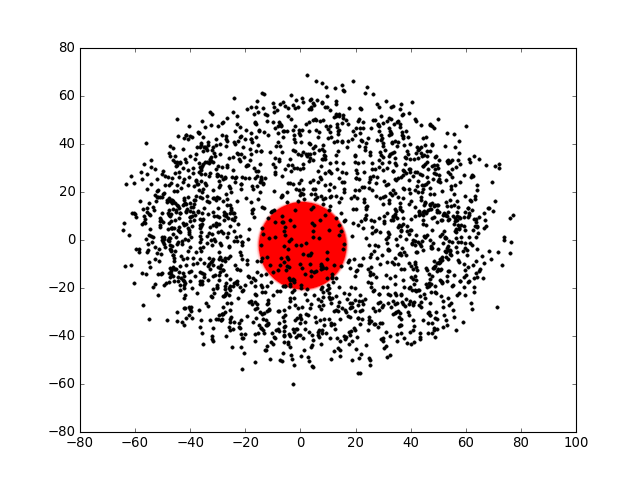

In [108]:
fig, ax = plt.subplots()
plot_fit(fig, ax, {model['flat']:optimizer_kwargs['num_parameters']})

In [56]:
fit = minimize(
    args=(targets[:100],),
#     method='CG',
#     method="Newton-CG",
    method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=None),
    **post.scipy_postmap(optimizer_kwargs)
); fit

/usr/local/lib/python2.7/dist-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


KeyboardInterrupt: 

In [109]:
opt = optimizer(
#     identifier='adadelta',
#     identifier="adam",
    identifier="rmsprop",
    step_rate=1e-1,
#     step_rate=1.2,
#     momentum=0.9,
    args=climin_args,
    **post.climin_postmap(optimizer_kwargs)
)

In [110]:
human_readable_parameters = _model['parameters'] + _model['parameters_positive']
f = theano.function([model['flat']], human_readable_parameters)
old_num_params = f(opt.wrt)
        
with ignored(KeyboardInterrupt):
    for info in opt:  #every(n_batches, opt):
        num_params = f(opt.wrt)
        print "jacobiannames", str(model['flat'])
        print "jacobian", optimizer_kwargs['num_jacobian'](opt.wrt, targets[:batch_size])
        diff_params = [n - o for n, o in izip(num_params, old_num_params)]
        print("params")
        pprint(dict(zip(map(str, human_readable_parameters), num_params)))
        print("diff")
        pprint(dict(zip(map(str, human_readable_parameters), diff_params)))
        print
        plot_fit(fig, ax, {model['flat']:opt.wrt}, time_delay=None)

jacobiannames "z09:mean21:alpha9_softplus:beta+alpha9_softplus:var21_softplus"
jacobian [-553.91232314  178.71718934  392.5913547  -825.36902197 -297.17026763
  518.99427162 -129.68056464 -133.27371709]
params
{'alpha9_reparam': array(6.8811524560599206e-06),
 'beta+alpha9_reparam': array(10.142718433836512),
 'mean21_flat': array([ 10.12551579, -23.37655352]),
 'var21_reparam': array([ 0.00582719,  0.00543702]),
 'z09_flat': array([-22.572594  ,   6.69276955])}
diff
{'alpha9_reparam': 1.8654443885839001e-06,
 'beta+alpha9_reparam': -0.3162120829829167,
 'mean21_flat': array([-0.31621907,  0.31622574]),
 'var21_reparam': array([ 0.00157612,  0.0014708 ]),
 'z09_flat': array([ 0.31622326, -0.31618693])}

jacobiannames "z09:mean21:alpha9_softplus:beta+alpha9_softplus:var21_softplus"
jacobian [-548.31282329  172.86819853  384.29088399 -816.25797342 -291.50738057
  509.02945307 -120.05859821 -130.24143621]
params
{'alpha9_reparam': array(8.63066607459647e-06),
 'beta+alpha9_reparam': array

## testings

In [ ]:
optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], targets[:10])

In [ ]:
print "loss", optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], targets[:10])
print "jacobian", optimizer_kwargs['num_jacobian'](optimizer_kwargs['num_parameters'], targets[:10])

In [ ]:
print "loss", optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], targets[:10])
print "jacobian", optimizer_kwargs['num_jacobian'](optimizer_kwargs['num_parameters'], targets[:10])

In [ ]:
d3viz(optimizer_kwargs['num_jacobian'].wrapped.wrapped, "tmp/num_jacobian.html", match_by_names=True)
IFrame("tmp/num_jacobian.html", width=700, height=500)

In [ ]:
d3viz(optimizer_kwargs['num_loss'].wrapped.wrapped, "tmp/num_loss.html", match_by_names=True)
IFrame("tmp/num_loss.html", width=700, height=500)

In [ ]:
d3viz(optimizer_kwargs['loss'], "tmp/loss.html")
IFrame("tmp/loss.html", width=700, height=500)

# variational inference (with prior)

## Model

In [59]:
data_model = pm.Gauss(2, init_var=np.exp(-2))
data_model = Merge(data_model, parameters_positive=None) # fix outer variance
data_model

Merge15 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa23a4600c0 for function at 0x7fa2314c31b8>,
  'outputs': GaussianNoise8.outputs,
  'parameters': [mean13],
  'parameters_positive': []}

In [60]:
param_model_base = pm.DiagGauss(2)
param_model_normflows = [dm.RadialTransform()]

param_model = param_model_base
for transform in param_model_normflows:
    param_model = normalizing_flow(transform, param_model)  # returns Merge
param_model

normalized_flow6 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa249aadc20 for function at 0x7fa24195ea28>,
  'norm_det': RadialTransform6.norm_det,
  'outputs': RadialTransform6.outputs,
  'parameters': [z06, mean14],
  'parameters_positive': [alpha6, beta+alpha6, var14]}

In [61]:
prior = fix_params(pm.Gauss(2, init_var=np.exp(1)))
prior

Gauss9_fixed { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fa2434cf9f0 for function at 0x7fa230c5e758>,
  'outputs': GaussianNoise9.outputs,
  'parameters': [],
  'parameters_positive': []}

In [62]:
_model = variational_bayes(data_model, 'parameters', param_model, priors=prior)

# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
model = Merge(_model, Reparameterize(_model['parameters_positive'], softplus, softplus_inv))
model = Merge(model, Center(model['parameters']))
model = Merge(model, Flatten(model['parameters']))
model

Merge18 { 'flat': "z06_centered:mean14_centered:alpha6_softplus_centered:beta+alpha6_softplus_centered:var14_softplus_centered",
  'inputs': [],
  'kl_prior': variational_lower_bound3.kl_prior,
  'logP': <FunctionWrapper at 0x7fa2434cfc20 for function at 0x7fa25eba0e60>,
  'loglikelihood': <FunctionWrapper at 0x7fa23a4600c0 for function at 0x7fa2314c31b8>,
  'logposterior': variational_lower_bound3.logposterior,
  'logprior': variational_lower_bound3.logprior,
  'n_data': n_data,
  'norm_det': RadialTransform6.norm_det,
  'outputs': GaussianNoise8.outputs,
  'parameters': [],
  'parameters_positive': []}

## Fit Visualization

In [63]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

<IPython.core.display.Javascript object>


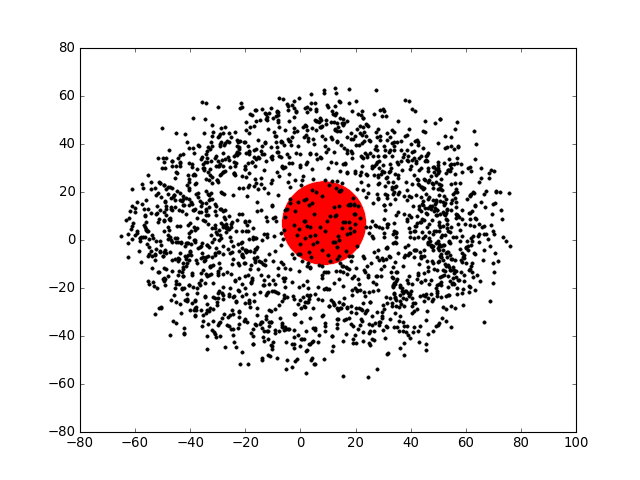

In [64]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

In [65]:
check_all_identities()
model['n_data'].set_value(n_samples)
# model['n_data'].set_value(1)

In [66]:
batch_size = 20
n_batches = len(targets) // batch_size
climin_args = izip( imap(lambda x:(x,),  chunk(20, cycle(targets)) ) , repeat({}))

def weights_data():
    for t in xrange(10000):
        yield min(1, 0.01 + t/10000)
    while True:
        yield 1
        
def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
postmap = compose(post.flat_numericalize_postmap, post.variational_postmap) 
    #post.normalizingflow_postmap) #post.variational_postmap), #post.probabilistic_optimizer_postmap
optimizer_kwargs = postmap(model,
    mapreduce=summap,
#     wrapper=as_wrapper(Average(30)),
    annealing_combiner=post.AnnealingCombiner(
#         weights_data=weights_data()
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.shape, scale=10)
)

In [67]:
opt = optimizer(
#     identifier='adadelta',
#     identifier="adam",
    identifier="rmsprop",
    step_rate=1e-1,
#     step_rate=1.2,
    momentum=0.9,
    args=climin_args,
    **post.climin_postmap(optimizer_kwargs)
)

In [68]:
human_readable_parameters = _model['parameters'] + _model['parameters_positive']
f = theano.function([model['flat']], human_readable_parameters)
old_num_params = f(opt.wrt)
        
with ignored(KeyboardInterrupt):
    for info in opt:  #every(n_batches, opt):
        num_params = f(opt.wrt)
        print "jacobian", optimizer_kwargs['num_jacobian'](opt.wrt, targets[:batch_size])
        diff_params = [n - o for n, o in izip(num_params, old_num_params)]
        print("params")
        pprint(dict(zip(map(str, human_readable_parameters), num_params)))
        print("diff")
        pprint(dict(zip(map(str, human_readable_parameters), diff_params)))
        print
        plot_fit(fig, ax, {model['flat']:opt.wrt}, time_delay=None)

jacobian [  1.37709294e-03  -2.08014314e-03  -3.44831919e+01  -9.33742791e+01
   4.23935839e-02  -3.38056299e-04   1.35563105e-02   1.26007968e+01]
params
{'Center4.outputs.0': array([-5.77094562, -7.97351803]),
 'Center4.outputs.1': array([-0.5633222 ,  0.67715784]),
 'alpha6_reparam': array(0.00046652251163323993),
 'beta+alpha6_reparam': array(3.719071268546718e-06),
 'var14_reparam': array([  4.51762717e-04,   1.24613130e+01])}
diff
{'Center4.outputs.0': array([ 0.00137709, -0.00208014]),
 'Center4.outputs.1': array([-34.48319185, -93.37427914]),
 'alpha6_reparam': 1.9359873409363106e-05,
 'beta+alpha6_reparam': -1.2574656641721546e-09,
 'var14_reparam': array([  6.08155626e-06,   1.18354795e+01])}

jacobian [  5.07765518e-04  -1.52937116e-03  -3.05849393e+01  -7.04041266e+01
   2.22518051e-02  -2.15451587e-04  -1.19300423e+00   9.43927139e+00]
params
{'Center4.outputs.0': array([-5.7762487 , -7.96781456]),
 'Center4.outputs.1': array([-0.02516209,  1.22467245]),
 'alpha6_reparam':

KeyboardInterrupt: 

In [ ]:
scipy_kwargs = post.scipy_postmap(optimizer_kwargs)

fit = minimize(
    args=(targets,),
#     method='CG',
#     method="Newton-CG",
    method="Nelder-Mead",
    options={'maxiter':1000, 'disp':True},
    callback=lambda params: plot_fit(fig, ax, {model['flat']:params}, time_delay=None),
    **scipy_kwargs
); fit

# test norm_Det

In [ ]:
tr = dm.RadialTransform(init_alpha=4, init_beta=5, init_z0=[5,2])

In [ ]:
f = theano.function(tr['inputs'], tr['norm_det'])

In [ ]:
f([1,2])

In [ ]:
from theano import gradient
from theano.tensor import nlinalg
jac = gradient.jacobian(tr['outputs'], tr['inputs'][0])
norm_det = nlinalg.Det()(jac)
f2 = theano.function(tr['inputs'], norm_det)

In [ ]:
f2([1,2])